Your main goal is to combine Linear Regression, Greedy Algorithm and PnL to predict trading results. Will be predicting Bitcoin price this time. 
Every prediction should be a result from a model that is trained based on the previous 400 days


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from itertools import combinations

In [3]:
pd.options.display.max_rows, pd.options.display.max_columns = 10, 25
BTC_price_origin =pd.read_csv('BTC-USD.csv')
BTC_price_origin

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-03-07,272.559998,278.250000,269.410004,274.910004,274.910004,16708000
1,2015-03-08,274.910004,278.779999,271.309998,274.489990,274.489990,13902830
2,2015-03-09,274.489990,293.260010,273.790009,290.019989,290.019989,43259194
3,2015-03-10,290.019989,300.959991,288.119995,291.369995,291.369995,46657647
4,2015-03-11,291.369995,297.660004,288.880005,295.600006,295.600006,23542829
...,...,...,...,...,...,...,...
1457,2019-03-03,3842.939941,3853.280029,3788.040039,3812.310059,3812.310059,64065044
1458,2019-03-04,3812.310059,3831.010010,3705.139893,3731.280029,3731.280029,147245676
1459,2019-03-05,3731.280029,3893.520020,3720.489990,3874.179932,3874.179932,165062256
1460,2019-03-06,3874.179932,3916.290039,3839.389893,3874.979980,3874.979980,129520549


In [4]:
stock_origin = BTC_price_origin[['Date','Close']]

stock_origin.index = stock_origin['Date'].values
del stock_origin['Date']
stock_origin

,Close
2015-03-07,274.910004
2015-03-08,274.489990
2015-03-09,290.019989
2015-03-10,291.369995
2015-03-11,295.600006
...,...
2019-03-03,3812.310059
2019-03-04,3731.280029
2019-03-05,3874.179932
2019-03-06,3874.979980


In [5]:
stock = stock_origin.copy()

# compute Return
stock['Return'] = stock.Close.diff()/stock.Close

# change index into date format
stock.index = pd.to_datetime(stock.index, format='%Y-%m-%d')
stock.index
stock

,Close,Return
2015-03-07,274.910004,NaN
2015-03-08,274.489990,-0.001530
2015-03-09,290.019989,0.053548
2015-03-10,291.369995,0.004633
2015-03-11,295.600006,0.014310
...,...,...
2019-03-03,3812.310059,-0.008034
2019-03-04,3731.280029,-0.021716
2019-03-05,3874.179932,0.036885
2019-03-06,3874.979980,0.000206


In [6]:
predictor_variables = ['1D','3D','1W','2W','3W','1M','6W','2M','3M','4M','5M','6M','9M','1Y']
# feature list
# create all features
def ShiftNum(var):
    if var[1]=='D':
        return int(var[0])
    elif var[1]=='W':
        return int(var[0])*5
    elif var[1]=='M':
        return int(var[0])*20
    elif var[1]=='Y':
        return int(var[0])*250
    else:
        return("Please give a str whose format is xD, xW, xM, xY.")

# shift Return by the value of each feature
for var in predictor_variables:
    name = 'Return_' + var
    stock[name] = stock.Return.shift(ShiftNum(var))

# drop the first 250 rows (cuz they do not have feature '1Y')
stock = stock.dropna()
target = ['Return']

In [7]:
fix_history_length = 400
fix_test_length = 100
sample_size = 50
# the range of t
randomRange = len(stock)-fix_history_length-fix_test_length
features=['Close', 'Return_1D', 'Return_3D', 'Return_1W', 'Return_2W',
       'Return_3W', 'Return_1M', 'Return_6W', 'Return_2M', 'Return_3M',
       'Return_4M', 'Return_5M', 'Return_6M', 'Return_9M', 'Return_1Y']
print(randomRange)

711


In [57]:
# compute Long-short value
def computation(df):
    for i in range(1,len(df)):
        if df.iloc[i,1]>=0:
            df.iloc[i,2] = df.iloc[i-1,2] * (1 + df.iloc[i,0])
        else:
            df.iloc[i,2] = df.iloc[i-1,2] * (1 - df.iloc[i,0])
    return df
def PnL(data, target, proportion):

    train_sub, valid_sub = train_test_split(data, test_size = proportion, random_state = 0)

    # create a linear model
    X_train = train_sub.drop(target, axis = 1)
    Y_train = train_sub[target]
    X_valid = valid_sub.drop(target, axis = 1)
    Y_valid = valid_sub[target]
    
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    Y_valid_fit = model.predict(X_valid)   

    # a data frame for computing and saving long_short value
    long_short_df = pd.DataFrame({'Return': Y_valid.iloc[:,0].values,
                                  'Predicted Return': Y_valid_fit.reshape(1,-1)[0].tolist(),
                                  'Long-short value': np.zeros(len(valid_sub))},
                                 index = valid_sub.index)
    
    cols = ['Return', 'Predicted Return', 'Long-short value']
    long_short_df = long_short_df[cols]
    
    # give an initial point
    initial = pd.DataFrame(np.array([0,0,1]).reshape(-1,3),
                       columns = long_short_df.columns)

    # combine df and initial point
    long_short_df = pd.concat([initial, long_short_df])

    # compute long_short value
    long_short_df_final = computation(long_short_df)
    
    

    # return final long_short value of this period
    return long_short_df_final.iloc[-1,2]

In [58]:
def greedy_algo(train_valid, target, proportion):
    
    # initialize a list to save features
    greedy_select = []
    
    profit_greedy_algo = np.array([])
    for i in range(len(features)):
        profit = np.array([])
        features_left = list(set(features) - set(greedy_select))

        for new in features_left:
            features_new = greedy_select + [new]
            train_valid_sub = train_valid[features_new + target]

            # CrossValidation, compute the profit and save it into profit_sub
            profit_sub = PnL(train_valid_sub, target, proportion)
            profit = np.append(profit, profit_sub)

        # pick the features that gives the largest profit
        # and add it into our features list
        # meanwhile, save the corresponding profit
        greedy_select += [features_left[profit.argmax()]]
        profit_greedy_algo = np.append(profit_greedy_algo, profit.max())
        
    return greedy_select[:(profit_greedy_algo.argmax()+1)]


In [59]:
profit_final = np.array([])

# Think about why we need two loops here:
# The answer is that this time, we need to change the training data for each day, each sample
# In total, we have 50 samples
for j in range(sample_size):
    np.random.seed(j)
    for i in range(fix_test_length): 
        random_Num =  np.random.randint(randomRange)
        BeginTime = random_Num 
        beg_limit=BeginTime+fix_history_length
        limit=beg_limit+fix_test_length
        #Filter  and test/train split last 400 dates
        train_valid=stock[BeginTime:beg_limit]
        test = stock[beg_limit:limit]
        train_valid = train_valid.reset_index(drop = True)
        test = test.reset_index(drop = True)
        ...

        features_cv = greedy_algo(train_valid,target,0.2)
        ...
        X_cv = train_valid[features_cv]
        Y_cv = train_valid[target]
        X_test_cv = test[features_cv]
        Y_test_cv = test[target]
        model_cv = linear_model.LinearRegression()
        model_cv.fit(X_cv, Y_cv)
        Y_test_cv_fit = model_cv.predict(X_test_cv)
        long_short_df = pd.DataFrame({'Return': Y_test_cv.values.reshape(1,-1)[0].tolist(),
                                      'Predicted Return': Y_test_cv_fit.reshape(1,-1)[0].tolist(),
                                      'Long-short value': np.zeros(len(Y_test_cv))},
                                     index = Y_test_cv.index)
        cols = ['Return', 'Predicted Return', 'Long-short value']
        long_short_df = long_short_df[cols]
        initial = pd.DataFrame(np.array([0,0,1]).reshape(-1,3), 
                               columns = long_short_df.columns)
        long_short_df = pd.concat([initial, long_short_df])
        long_short_df_final = computation(long_short_df)
    profit_final = np.append(profit_final,long_short_df_final.iloc[-1,2])
print(profit_final)

[0.36685107 1.90075342 1.06897017 2.26360766 0.89258145 0.63139541
 0.83342753 0.80349318 1.07493998 1.07407816 0.75132336 0.48325539
 1.1165358  0.67837267 1.86032841 0.37212979 1.55299611 1.58130451
 1.05000059 0.75639879 0.5210792  1.54293813 0.90892501 0.70720938
 0.95676926 1.94423005 1.21718828 1.46961674 1.1499853  0.30594945
 2.57311981 0.49305002 2.06166376 1.35433106 2.25573376 1.68239289
 1.24428714 1.51018119 0.70902186 1.24222876 0.93133162 1.56156538
 0.49305002 0.61835003 1.48574398 0.98082516 0.66375061 1.21264101
 1.26165354 1.01666235]


Text(0.3, 14, '100 test points')

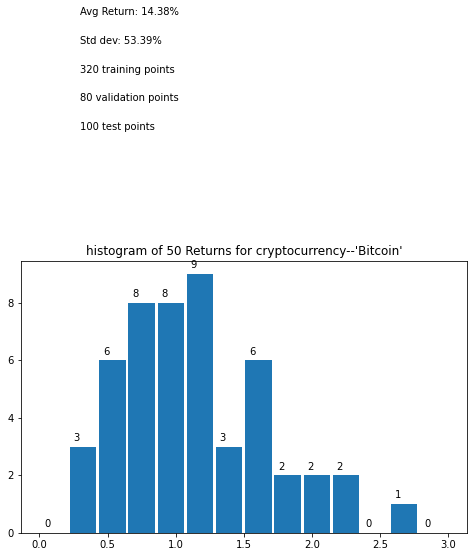

In [8]:
profit_final=np.array([0.36685107, 1.90075342, 1.06897017, 2.26360766, 0.89258145, 0.63139541
 ,0.83342753 ,0.80349318 ,1.07493998 ,1.07407816 ,0.75132336 ,0.48325539
 ,1.1165358  ,0.67837267 ,1.86032841 ,0.37212979 ,1.55299611 ,1.58130451
 ,1.05000059 ,0.75639879 ,0.5210792  ,1.54293813 ,0.90892501 ,0.70720938
 ,0.95676926 ,1.94423005 ,1.21718828 ,1.46961674 ,1.1499853  ,0.30594945
 ,2.57311981 ,0.49305002 ,2.06166376 ,1.35433106 ,2.25573376 ,1.68239289
 ,1.24428714 ,1.51018119 ,0.70902186 ,1.24222876 ,0.93133162 ,1.56156538
 ,0.49305002 ,0.61835003 ,1.48574398 ,0.98082516 ,0.66375061 ,1.21264101
 ,1.26165354 ,1.01666235])
fig = plt.figure(figsize=(8,5))
bins = np.linspace(0, 3, 15)
a = plt.hist(profit_final, bins, histtype='bar', rwidth=0.9)
for i in range(len(bins)-1):
    plt.text(a[1][i]+0.037,a[0][i]+0.2,int(a[0][i]))
plt.title("histogram of 50 Returns for cryptocurrency--'Bitcoin'")

# you should change the coordinates of the plot to make it look nice
plt.text(0.3, 18, ("Avg Return: {0:.2f}%".format((profit_final.mean()-1) * 100)))
plt.text(0.3, 17, ("Std dev: {0:.2f}%".format(profit_final.std() * 100)))
plt.text(0.3, 16, "320 training points")
plt.text(0.3, 15, "80 validation points")
plt.text(0.3, 14, "100 test points")